In [1]:
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
from scipy.integrate import odeint
# import pandas as pd 
import pickle
import sys
import os
sys.path.append(os.path.abspath("..")) # Adds the parent folder to sys.path
from utils import *
from Robots import *
from Controller import *
from Neural_Nets import *

# Load trained ML model

In [2]:
relative_path = os.getcwd()
relative_path = os.path.abspath("..")
dataset_fn = relative_path + '/data' + '/single_H10.p'
prob_features = ['x0', 'xg']

data_file = open(dataset_fn,'rb')
all_data = pickle.load(data_file)
data_file.close()
data_list = []
num_train = len(all_data)

X0 = np.vstack([all_data[ii]['x0'].T for ii in range(num_train)])  
XG = np.vstack([all_data[ii]['xg'].T for ii in range(num_train)])  
OBS = np.vstack([all_data[ii]['xg'].T for ii in range(num_train)])  
YY = np.concatenate([all_data[ii]['YY'].astype(int) for ii in range(num_train)], axis=1).transpose(1,0,2)

train_data = [{'x0': X0, 'xg': XG}, None, None, YY, None]

# load the ML model from file 
n_features = 6
mlopt = CoCo(prob_features)
mlopt.construct_strategies(n_features, train_data)
# The best one so far
mlopt.setup_network(depth=3, neurons=256)
fn_saved = 'trained/CoCo_20250219_1544.pt'
mlopt.load_network(fn_saved)

# lstm = PRISM(prob_features)
# lstm.construct_strategies(n_features, train_data)
# ff_neurons=256; lstm_neurons=128; lstm_lay = 3
# lstm.setup_network(ff_neurons, lstm_neurons, lstm_lay)
# fn_saved = 'trained/PRISM_20250217_1845.pt'
# lstm.load_network(fn_saved)


Loading presaved classifier model from trained/CoCo_20250219_1544.pt


# Setup the testing simulation

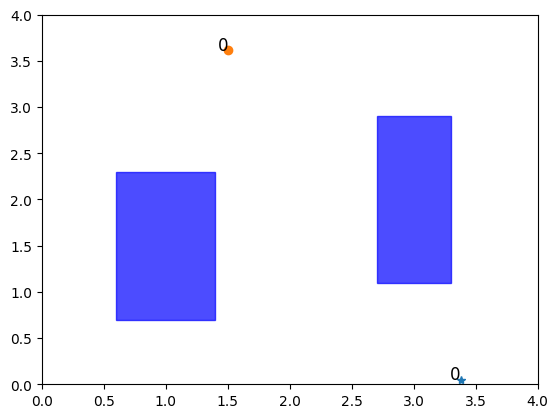

In [3]:
# List of obstacles
with_obs = True
if with_obs:
    Obs = [
        obstacle(1.0, 1.5, 0.8, 1.6, 0.),
        obstacle(3.0, 2.0, 1.8, 0.6, np.pi/2)
    ]
else:
    Obs = []
n_obs = len(Obs)
Obs_info = np.array([[o.x_c, o.y_c, o.theta, o.L, o.W] for o in Obs]).T

bounds = {
    "x_max": 4.0, "x_min": 0.0, 
    "y_max": 4.0, "y_min": 0.0,
    "v_max": 0.5, "v_min": -0.5, 
    "u_max": 0.5, "u_min": -0.5, 
}
d_min = 0.25
M = 1
# generate the goal positions
# np.random.seed(45)
goals = goal_position(Obs, bounds, d_min+0.1, M)

# generate the initial position so that no collision avoidance constraint is violated
p_init = init_position(Obs, goals, bounds, d_min+0.1, M, d_sep = 4.0, d_dec = 4.0/100)

# Visualize the scenario
from matplotlib.patches import Polygon
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"]) 
ax.set_ylim(bounds["y_min"], bounds["y_max"]) 
ax.plot(goals[0, :], goals[1, :], "*")
for i in range(goals.shape[1]):
    ax.text(goals[0, i], goals[1, i], str(i), fontsize=12, ha='right')
ax.plot(p_init[0, :], p_init[1, :], "o")
for i in range(p_init.shape[1]):
    ax.text(p_init[0, i], p_init[1, i], str(i), fontsize=12, ha='right')

for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)


In [4]:
T = 0.4; H = 10

#create numpy containers for data: (params, x, u, y, J*, solve_time)
sampled_params = ['x0', 'xg', 'obstacles']
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros([0, 4])
if 'xg' in sampled_params:
    params['xg'] = np.zeros([0, 4])
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((0, 5, len(Obs)))


In [5]:
Robots = [robot(T, p_init[:,i], np.zeros(2)) for i in range(M)]
all_p = np.hstack([rob.p for rob in Robots])
all_v = np.hstack([rob.v for rob in Robots])

Ctrl = controller(T, H, M)
Ctrl.set_params(bounds, d_min, Wu=1e0, Wp=1e0, Wpt=1e1)
Ctrl.set_goals_obstacles(goals, Obs)
Ctrl.set_state(all_p, all_v)
Ctrl.find_cpl_rbs(d_prox=2.0)
Ctrl.solve_MIQP()
print("From MIQP solver \n", Ctrl.SOL_disc["BO"].astype(int))
which_model = 1
if which_model == 1:
    FCtrl = fast_controller(T, H, M, mlopt, "MLOpt")
elif which_model == 2:
    FCtrl = fast_controller(T, H, M, lstm, "LSTM")
FCtrl.set_params(bounds, d_min, Wu=1e0, Wp=1e0, Wpt=1e1)
FCtrl.set_goals_obstacles(goals, Obs)
FCtrl.set_state(all_p, all_v)

# test predict the binary with ML model
new_params = {}
new_params['x0'] = np.hstack([all_p, all_v])
new_params['xg'] = np.hstack([Ctrl.goals, np.zeros(2)])
new_params["obstacles"] = Obs_info[np.newaxis, :, :]
FCtrl.predict_binary(new_params)
print("From NN model \n", FCtrl.l_guess)
FCtrl.find_cpl_rbs()
FCtrl.solve_QP()

From MIQP solver 
 [[[1 1 1 1 1 0 0 0 0 0]]

 [[0 0 0 1 1 1 1 1 1 1]]]
From NN model 
 [[1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]]


In [6]:
# The main loop
N_step = 100
for t in range(N_step):
    print("Time step:", t)
    all_p = np.hstack([rob.p for rob in Robots])
    all_v = np.hstack([rob.v for rob in Robots])
    FCtrl.set_state(all_p, all_v)
    new_params['x0'] = np.hstack([all_p, all_v])
    t0 = time.time()
    FCtrl.predict_binary(new_params)
    FCtrl.solve_QP()
    t1 = time.time()
    print("Solving took", t1-t0, "seconds")

    U_ctrl = FCtrl.SOL_cont["U"][:, 0].reshape([2,-1], order = 'F')
    for i in range(M):
        Robots[i].run(U_ctrl[:,i], t*T)

    if FCtrl.reaching_goals():
        break

Time step: 0
Solving took 0.07182931900024414 seconds
Time step: 1
Solving took 0.07837057113647461 seconds
Time step: 2
Solving took 0.06997203826904297 seconds
Time step: 3
Solving took 0.060271501541137695 seconds
Time step: 4
Solving took 0.07802009582519531 seconds
Time step: 5
Solving took 0.08162569999694824 seconds
Time step: 6
Solving took 0.06712579727172852 seconds
Time step: 7
Solving took 0.06525254249572754 seconds
Time step: 8
Solving took 0.07203841209411621 seconds
Time step: 9
Solving took 0.08676290512084961 seconds
Time step: 10
Solving took 0.07284307479858398 seconds
Time step: 11
Solving took 0.07412409782409668 seconds
Time step: 12
Solving took 0.0737149715423584 seconds
Time step: 13
Solving took 0.06545138359069824 seconds
Time step: 14
Solving took 0.06445169448852539 seconds
Time step: 15
Solving took 0.06125926971435547 seconds
Time step: 16
Solving took 0.06859779357910156 seconds
Time step: 17
Solving took 0.07767891883850098 seconds
Time step: 18
Solvin

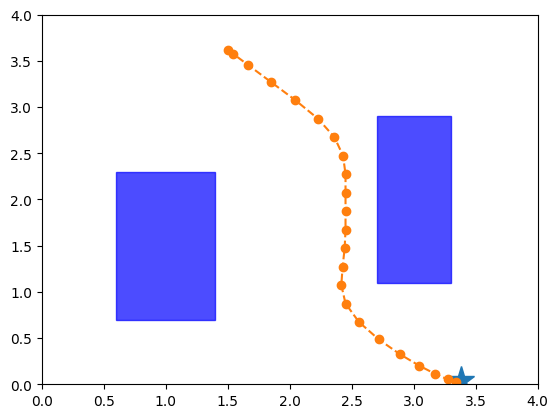

In [7]:
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"])
ax.set_ylim(bounds["y_min"], bounds["y_max"])
ax.plot(goals[0, :], goals[1, :], "*", markersize=20)
for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)
for rob in Robots:
    ax.plot(rob.X_hist[0,:], rob.X_hist[1, :], "o--")


# Video of the Navigation

In [ ]:
# Video of the Navigation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(bounds["x_min"], bounds["x_max"])
ax.set_ylim(bounds["y_min"], bounds["y_max"])

# Static elements
ax.plot(goals[0, :], goals[1, :], "*", markersize=20)  # Plot goals
for o in Obs:
    corners = [o.p1, o.p2, o.p3, o.p4]
    polygon = Polygon(corners, closed=True, color="b", alpha=0.7)
    ax.add_patch(polygon)

# Dynamic elements
robot_lines = []
for rob in Robots:
    line, = ax.plot([], [], "o--")  # Initialize empty lines for robots
    robot_lines.append(line)

# Initialization function
def init():
    for line in robot_lines:
        line.set_data([], [])
    return robot_lines

# Update function
def update(frame):
    for rob, line in zip(Robots, robot_lines):
        line.set_data(rob.X_hist[0, :frame+1], rob.X_hist[1, :frame+1])
    return robot_lines

# Create animation
num_frames = Robots[0].X_hist.shape[1]
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)

# Save or display the animation
HTML(ani.to_html5_video())
# plt.show()  # Uncomment this to display in an interactive session
